In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import scanpy.external as sce

In [2]:
predata = sc.read_text('./VEN4FS_scaled.data.txt')

In [3]:
predata = sc.AnnData(predata.X.T, obs=predata.var, var=predata.obs)

In [4]:
adata = predata

In [5]:
adata.obs['Cell name'] = adata.obs.index
adata.obs['celltype'] = adata.obs_names.str.extract(r'^(cVEN|PC|ETPC2|ETPC|TRI)', expand=False)

In [6]:
adata.obs

,Cell name,celltype
PC02,PC02,PC
PC04,PC04,PC
PC06,PC06,PC
PC08,PC08,PC
PC09,PC09,PC
...,...,...
PC66,PC66,PC
cVEN21,cVEN21,cVEN
PC67,PC67,PC
PC68,PC68,PC


In [7]:
def pre(adata, selected_cell_type):
    # 创建一个映射将所有细胞类型映射为 0
    cell_type_mapping = {cell: 0 for cell in adata.obs['celltype'].unique()}
    # 将选定的细胞类型映射为细胞名
    cell_type_mapping[selected_cell_type] = 1
    # 将细胞类型映射应用到数据框中
    adata.obs['new_celltype'] = adata.obs['celltype'].map(cell_type_mapping)

    return adata

In [8]:
pre(adata, 'cVEN')

AnnData object with n_obs × n_vars = 124 × 54817
    obs: 'Cell name', 'celltype', 'new_celltype'

In [9]:
adata.obs['new_celltype'].value_counts()

new_celltype
0    102
1     22
Name: count, dtype: int64

In [10]:
Temporal_data = adata
# # 使用默认整数索引
Temporal_data.obs.reset_index(drop=True, inplace=True)
Temporal_data.obs

,Cell name,celltype,new_celltype
0,PC02,PC,0
1,PC04,PC,0
2,PC06,PC,0
3,PC08,PC,0
4,PC09,PC,0
...,...,...,...
119,PC66,PC,0
120,cVEN21,cVEN,1
121,PC67,PC,0
122,PC68,PC,0


In [71]:
# 特征选择处理
X = Temporal_data.X
y = Temporal_data.obs['new_celltype'].values

np.int = int
np.float = float
np.bool = bool

In [72]:
rf = RandomForestClassifier(n_jobs=20, class_weight='balanced', max_depth=8)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)

#6,6
# find all relevant features - 5 features should be selected#10,6
feat_selector.fit(X, y)
feat_selector.support_
# check ranking of features
feat_selector.ranking_
rank = feat_selector.ranking_

In [73]:
X_List = []
for i,item in enumerate(rank):
    if item==1:
        X_List.append(Temporal_data.var_names[i])
            
print(X_List)

['AC006460.2', 'AC025287.3', 'AC027279.1', 'AC130466.1', 'AC239860.1', 'ACSL3', 'ADRA1A', 'AK5', 'AL512590.1', 'AL669831.5', 'ARHGAP1', 'ATP2C1', 'ATP8A1', 'AZIN1', 'BCL6B', 'C11orf65', 'C6orf163', 'CAMK1D', 'CD81', 'CDHR3', 'CLIC6', 'CLMP', 'COL21A1', 'DCHS1', 'DNAJA1', 'DNAJA4', 'EPHA6', 'FAM111A-DT', 'FAM126B', 'GNG2', 'GRIA4', 'HNRNPA2B1', 'INPP5A', 'LINC01845', 'MADD', 'MAP2K1', 'MEIS2', 'MMD', 'MTURN', 'NCALD', 'NDFIP2', 'NPTX1', 'NUDT11', 'NUDT4', 'OLFM1', 'OPTN', 'PABPC1', 'PCDH9', 'PDP1', 'PLA2G12B', 'PLEKHB2', 'POU3F1', 'PTPRK', 'REEP5', 'RNF41', 'RXFP1', 'SERPINF1', 'SH3BGRL2', 'SLC17A7', 'SLC27A5', 'SLC35F2', 'SLC5A8', 'SLC7A14', 'SLITRK1', 'SP110', 'SPOCK1', 'SULF2', 'SYN2', 'SYT1', 'SYTL2', 'TFRC', 'TRIM28', 'ZNF891']


In [74]:
# 获取选择的基因在adata中的表达情况
expression_data = Temporal_data[:,X_List].X

# 计算每列平均值
mean_expression = expression_data.mean(axis=0).flatten()

# 创建一个 Pandas DataFrame，其中包含基因和它们的平均表达值
gene_expression_df = pd.DataFrame({'Gene': X_List, 'Mean_Expression': mean_expression})

# 按平均表达值降序排序
sorted_gene_expression_df = gene_expression_df.sort_values(by='Mean_Expression', ascending=False)

# 获取排序后的基因列表
sorted_gene_list = sorted_gene_expression_df['Gene'].tolist()

# 打印结果
print(f"Bourta算法选出的基因共{len(sorted_gene_list)}个，基因名如下：{sorted_gene_list}")

Bourta算法选出的基因共73个，基因名如下：['NUDT4', 'SH3BGRL2', 'SLC27A5', 'NDFIP2', 'AC006460.2', 'MMD', 'FAM126B', 'HNRNPA2B1', 'NPTX1', 'OLFM1', 'REEP5', 'MEIS2', 'DNAJA4', 'SYTL2', 'TRIM28', 'DCHS1', 'SYN2', 'PLEKHB2', 'SLC17A7', 'SERPINF1', 'CAMK1D', 'TFRC', 'NCALD', 'AC025287.3', 'AK5', 'AC027279.1', 'PTPRK', 'RXFP1', 'C6orf163', 'CD81', 'ATP8A1', 'BCL6B', 'AC130466.1', 'SLC5A8', 'SP110', 'INPP5A', 'GNG2', 'GRIA4', 'SLITRK1', 'ACSL3', 'CLMP', 'SLC7A14', 'DNAJA1', 'AL669831.5', 'ARHGAP1', 'C11orf65', 'AZIN1', 'NUDT11', 'PCDH9', 'FAM111A-DT', 'EPHA6', 'ZNF891', 'MAP2K1', 'PLA2G12B', 'COL21A1', 'PABPC1', 'CDHR3', 'SYT1', 'CLIC6', 'SULF2', 'ATP2C1', 'SLC35F2', 'MTURN', 'PDP1', 'LINC01845', 'ADRA1A', 'OPTN', 'RNF41', 'SPOCK1', 'AL512590.1', 'AC239860.1', 'MADD', 'POU3F1']


    Cell name celltype  new_celltype
0        PC02       PC             0
1        PC04       PC             0
2        PC06       PC             0
3        PC08       PC             0
4        PC09       PC             0
..        ...      ...           ...
119      PC66       PC             0
120    cVEN21     cVEN             1
121      PC67       PC             0
122      PC68       PC             0
123    cVEN22     cVEN             1

[124 rows x 3 columns]


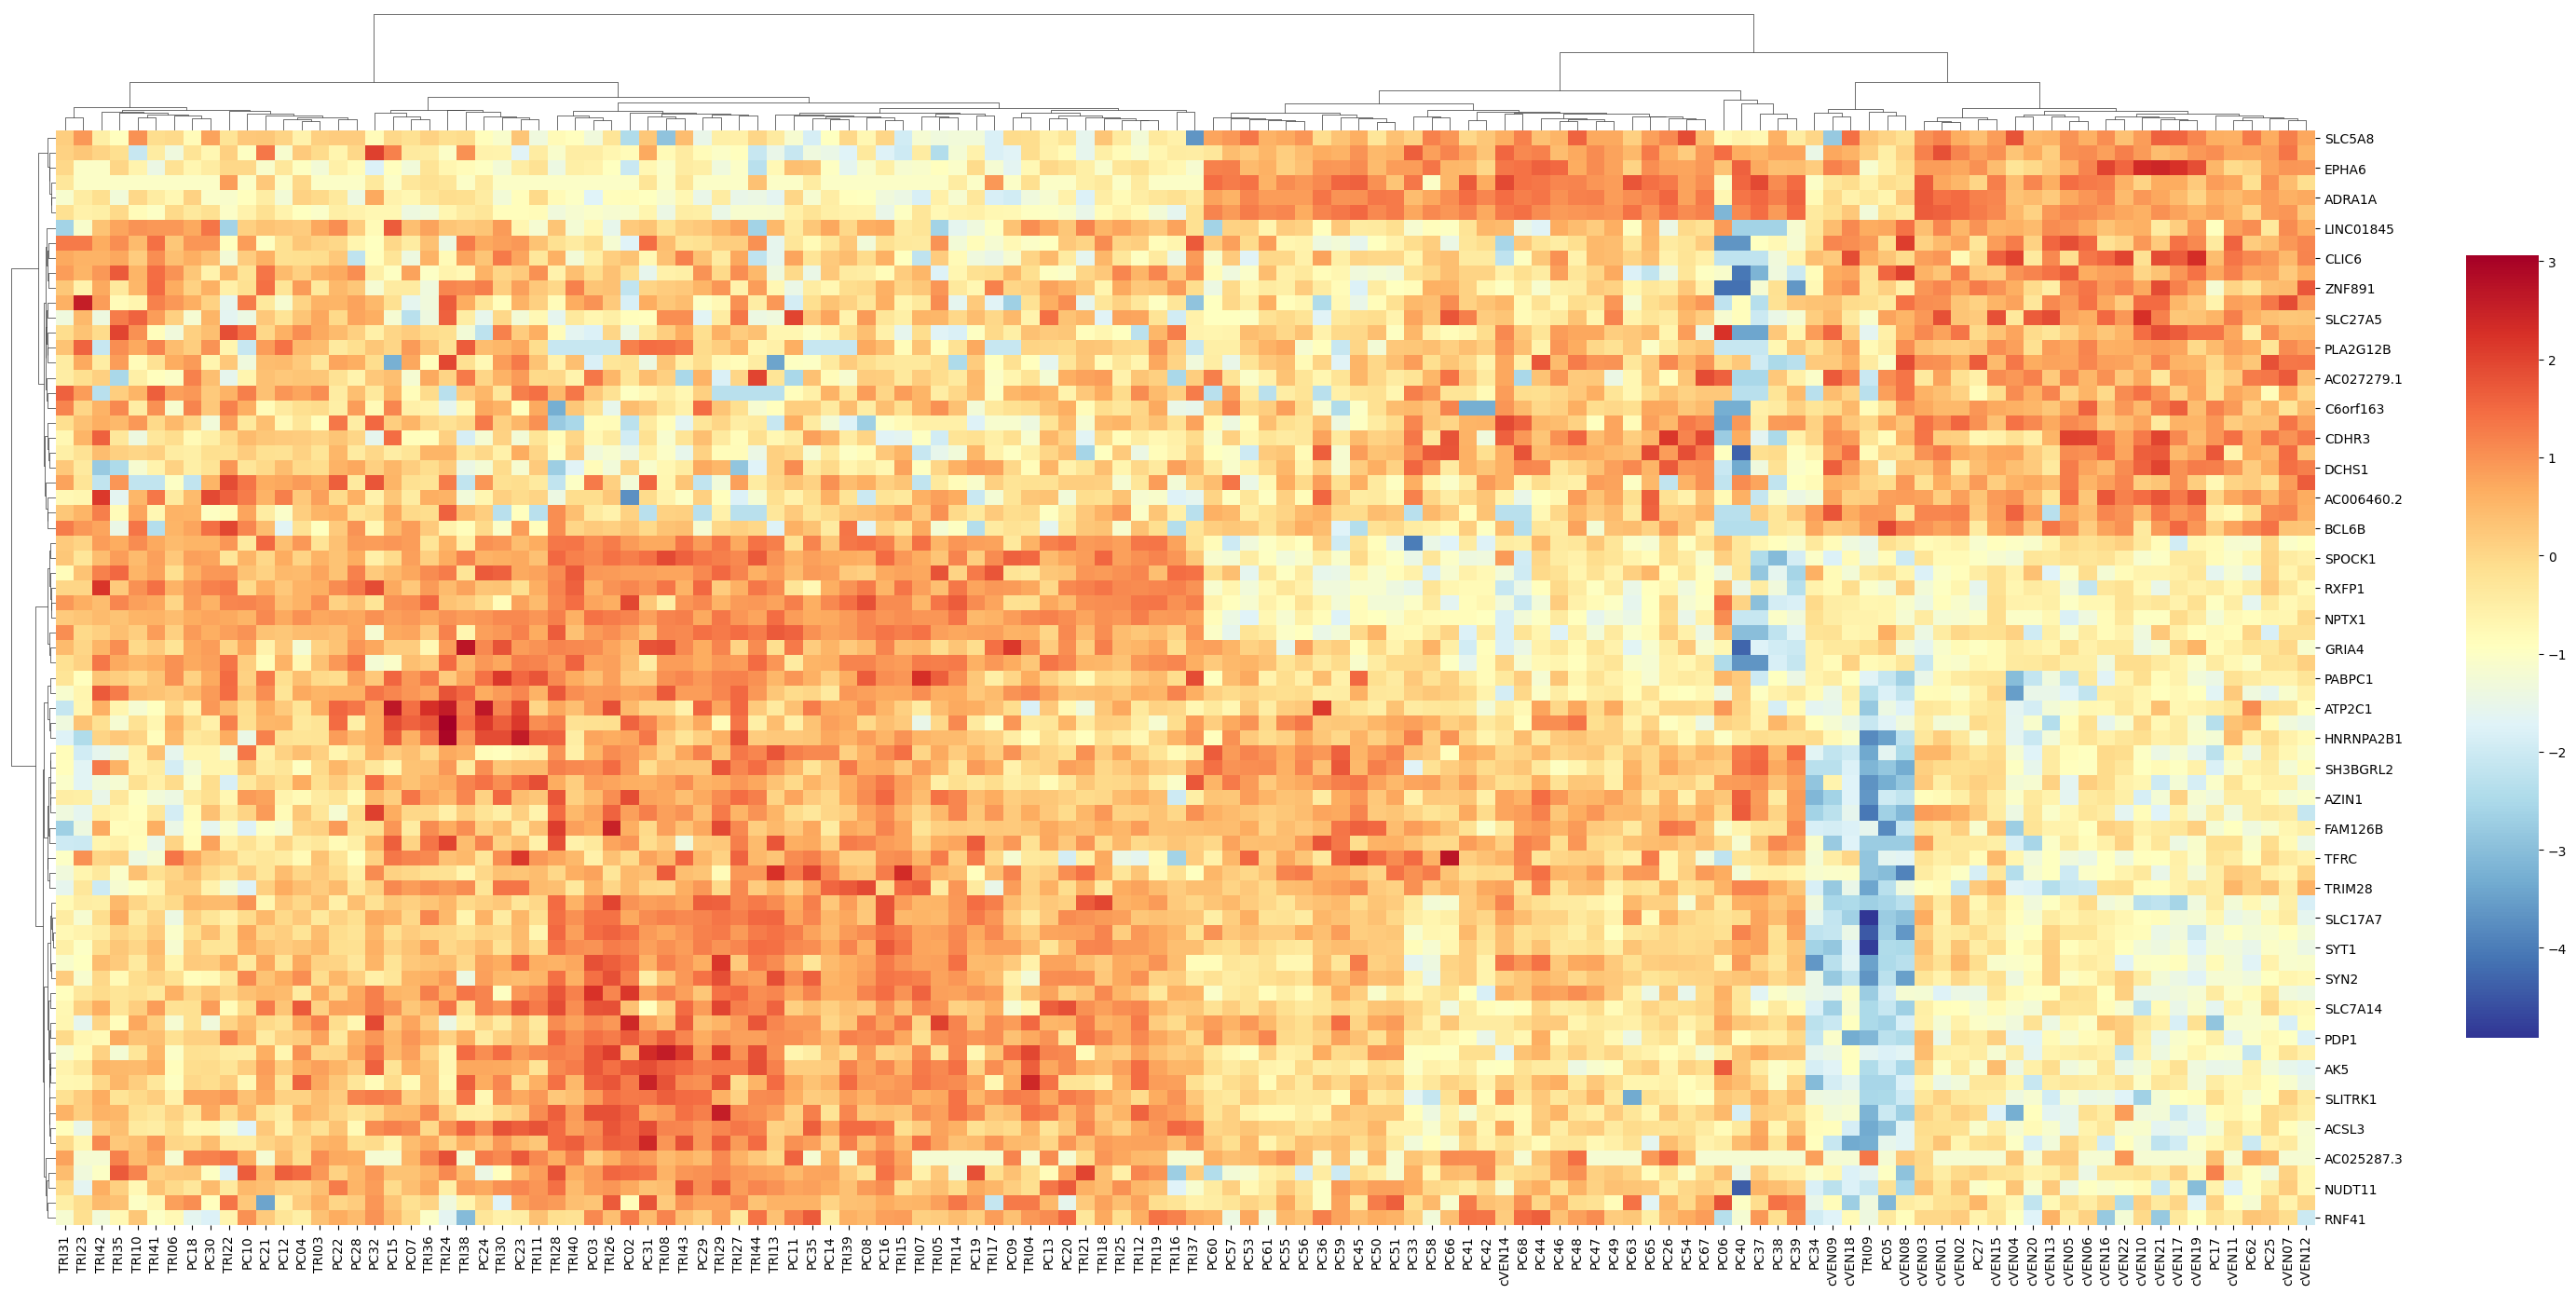

In [76]:
selected_genes_mask1 = Temporal_data.var_names.isin(sorted_gene_list[:])
# 通过布尔掩码更新数据
Temporal_adata_10 = Temporal_data[:, selected_genes_mask1]
print(Temporal_adata_10.obs)

data_exp1 = Temporal_adata_10.X.toarray()
draw_gene1 = Temporal_adata_10.var.index.tolist()
draw_cell1 = Temporal_adata_10.obs['Cell name'].tolist()
df_draw1 = pd.DataFrame(data_exp1, index=draw_cell1, columns=draw_gene1)

clustergrid1 = sns.clustermap(df_draw1.T,col_cluster=True,method='ward',dendrogram_ratio=(0.02, 0.10), cmap='RdYlBu_r', figsize=(26, 14),cbar_pos=(1.02, 0.2, 0.03, 0.6)) # 设置颜色条的位置和大小)#,metric='cosine'


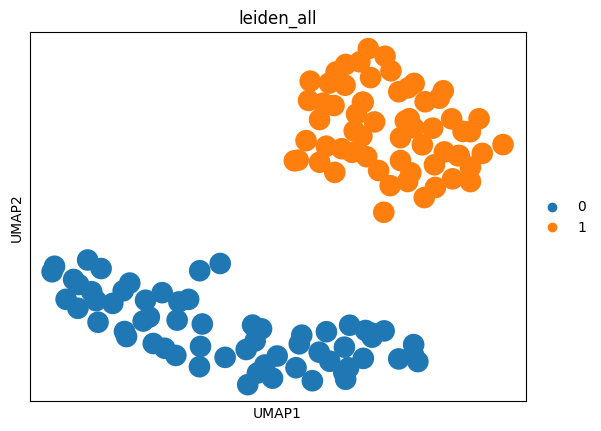

In [78]:
sc.pp.neighbors(Temporal_adata_10, n_neighbors=15)
sc.tl.umap(Temporal_adata_10)
sc.tl.leiden(Temporal_adata_10, key_added="leiden_all", resolution=0.3)
sc.pl.umap(Temporal_adata_10, color="leiden_all", show=False)

plt.show()

In [79]:
Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '0']

,Cell name,celltype,new_celltype,leiden_all
12,PC17,PC,0,0
20,TRI31,TRI,0,0
21,PC25,PC,0,0
22,PC26,PC,0,0
23,PC27,PC,0,0
...,...,...,...,...
119,PC66,PC,0,0
120,cVEN21,cVEN,1,0
121,PC67,PC,0,0
122,PC68,PC,0,0


In [80]:
print(len(Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '0']))

62


In [81]:
Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '0']['Cell name'].values

array(['PC17', 'TRI31', 'PC25', 'PC26', 'PC27', 'PC05', 'TRI09', 'TRI23',
       'cVEN01', 'cVEN02', 'cVEN03', 'cVEN04', 'cVEN05', 'cVEN06',
       'cVEN07', 'cVEN08', 'cVEN14', 'PC37', 'PC38', 'PC39', 'PC40',
       'PC41', 'PC42', 'cVEN09', 'cVEN10', 'cVEN11', 'PC33', 'PC34',
       'cVEN12', 'cVEN13', 'PC36', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48',
       'PC49', 'PC50', 'PC51', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57',
       'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'cVEN15', 'cVEN16',
       'cVEN17', 'cVEN18', 'cVEN19', 'cVEN20', 'PC65', 'PC66', 'cVEN21',
       'PC67', 'PC68', 'cVEN22'], dtype=object)